In [1]:
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# **Aprendizagem Supervisionada - Projeto Final**

## **Ranqueamento de Urgência das Reclamações do Consumidor.gov**

Professor: Aléssio Tony <br>
Aluno: Pedro Henrique Medeiros Vieira - 20220092900

### **Objetivo**

O objetivo **principal** será calcular a probabilidade de uma reclamação não ser resolvida e criar um ranquemento de reclamações prioritárias.

Outras ideias:

- **Classificação de tipo de problema mais frequente**<br>
    **Objetivo:** Classificar automaticamente as reclamações em categorias de problemas (ex: cobrança indevida, produto com defeito etc.), mesmo quando o usuário escreve de forma livre.

  - **Técnica:** NLP + Classificação Multiclasse (ex: Logistic Regression, Random Forest, BERT)
  - **Uso:** Facilita o direcionamento da demanda para a equipe correta.
  
- **Previsão de tempo de resposta ou resolução**<br>
    **Objetivo:** Estimar em quantos dias uma reclamação será respondida ou resolvida.

  - **Técnica:** Regressão (ex: XGBoost, SVR)
  - **Variáveis úteis:** Data da reclamação, empresa, tipo de produto, canal, localização.

- **Sistema de recomendação de ações para o consumidor**<br>
    **Objetivo:** Dado o conteúdo da reclamação e outras variáveis, sugerir o que o consumidor pode fazer (ex: entrar em contato com PROCON, abrir processo no Juizado, aguardar prazo médio, etc.)

  - **Técnica:** Regras + Classificação baseada em casos anteriores (similaridade)

---

### **Análise Exploratória de Dados e Preparação**

O presente notebook contém as análises de dados exploratórias desenvolvidas para extrair insights para a preparação e modelagem do projeto.

Os dados foram extraídos do site: [Consumidor.gov](https://consumidor.gov.br/pages/indicador/relatos/abrir), um site em que consumidores e empresas resolvem conflitos de consumo por meio da internet, sem precisar de um processo judicial.

A extração foi automatizada por WebScrapping, com Selenium e BeatifulSoup.

In [2]:
# Import modules
from pandas import read_csv
import os

In [3]:
# Files vars
data_dir = 'data'
staging_dir = 'staging_area'
ml_dir = 'ml'
staging_data_name = 'consumidor_gov_brasil.csv'
ml_data_name = 'consumidor_gov_brasil_ml.csv'

root_path = os.path.dirname(os.getcwd())

staging_path = os.path.join(root_path, data_dir, staging_dir)
ml_path = os.path.join(root_path, data_dir, ml_dir)

staging_file_path = os.path.join(staging_path, staging_data_name)
ml_file_path = os.path.join(ml_path, ml_data_name)

In [4]:
# Data reading
data = read_csv(staging_file_path, sep='|', encoding='utf-8')
data.head()

,company_name,status,date,report,company_response,response_date,rating_score,consumer_written_evaluation
0,Serasa Experian,Não Resolvido,"25/04/2025, Santa Maria - RS",Solicito a imediata retirada da negativação in...,"Oi, FLAVIA. Tudo bem?\r\n\r\n\r\nAcabamos de r...",(no mesmo dia),Nota 2,<não há comentários do consumidor>
1,Serasa Experian,Não Resolvido,"25/04/2025, Santa Tereza do Oeste - PR",“Solicito a retirada imediata da dívida prescr...,"Oi, KARINA. Tudo bem?\r\n\r\n\r\nAcabamos de r...",(no mesmo dia),Nota 1,<não há comentários do consumidor>
2,Serasa Experian,Resolvido,"25/04/2025, Manaus - AM",Solicito a imediata retirada da negativacão in...,"Oi, EMERSON. Tudo bem?\r\n\r\n\r\nAcabamos de ...",(no mesmo dia),Nota 1,<não há comentários do consumidor>
3,Serasa Experian,Não Resolvido,"25/04/2025, Macapá - AP",Solicito a retirada imediata de cobrança de dí...,"Oi, Washington. Tudo bem?\r\n\r\n\r\nAcabamos ...",(no mesmo dia),Nota 3,<não há comentários do consumidor>
4,Cartões Renner (Realize CFI),Resolvido,"25/04/2025, Rio Grande da Serra - SP",Realizei o pagamento de um acordo para quitar ...,"Olá, tudo bem?\r\n\r\nInformamos que sua manif...",(no mesmo dia),Nota 1,<não há comentários do consumidor>


In [5]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   company_name                 50000 non-null  object
 1   status                       50000 non-null  object
 2   date                         50000 non-null  object
 3   report                       50000 non-null  object
 4   company_response             50000 non-null  object
 5   response_date                49505 non-null  object
 6   rating_score                 50000 non-null  object
 7   consumer_written_evaluation  31675 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


Dados em formatos errados:

- Date: Possui local e data
- Response_Date: Possui texto
- Rating_Score: Em texto

In [6]:
# Dados nulos
data.isna().sum()

company_name                       0
status                             0
date                               0
report                             0
company_response                   0
response_date                    495
rating_score                       0
consumer_written_evaluation    18325
dtype: int64

In [7]:
# Visualizando dados nulos
data[data.isna().any(axis=1)]

,company_name,status,date,report,company_response,response_date,rating_score,consumer_written_evaluation
944,Serasa Experian,Resolvido,"21/04/2025, Belém - PA","Serasa vem mantendo cobrança, mesmos depois do...",<não respondido pela empresa>,NaN,Nota 5,foi rapido e bem satisfeitoo
4171,KaBuM!,Não Resolvido,"14/04/2025, Guarapari - ES","o pedido 43742339 feito ontem, 13/04 não aprov...",<não respondido pela empresa>,NaN,Nota 1,a empresa tem problemas sérios com cartão e pa...
4217,Usebens Seguradora,Não Resolvido,"14/04/2025, Itanhaém - SP",Copia apolice seguros emitidos,<não respondido pela empresa>,NaN,Nota 1,"nem respondeu, vou solciitar novamente"
4226,Hurb - Hotel Urbano,Não Resolvido,"14/04/2025, Brumado - BA",No dia 25/02/2025 fiz uma reserva pela Hurb no...,<não respondido pela empresa>,NaN,Nota 1,A empresa não forneceu nenhuma resposta.
4228,Hurb - Hotel Urbano,Não Resolvido,"14/04/2025, Vitória - ES",Comprei um Pacote de Viagem - Roma + Paris + A...,<não respondido pela empresa>,NaN,Nota 1,Solicitação sem qualquer resposta do fornecedo...
...,...,...,...,...,...,...,...,...
49995,Caixa Econômica Federal,Não avaliado pelo consumidor,"27/03/2025, Natal - RN",Em (data) verifiquei a o extrato ( cartão de c...,"Olá, Ivair!\r\n\r\nAnalisamos sua solicitação ...",(5 dia(s) depois),<não há comentários do consumidor>,NaN
49996,Banco Santander,Não avaliado pelo consumidor,"27/03/2025, Juiz de Fora - MG",Em (data) verifiquei a o extrato ( cartão de c...,"Olá, boa tarde!\r\n \r\nSeu atendimento foi re...",(4 dia(s) depois),<não há comentários do consumidor>,NaN
49997,Banco do Brasil,Não avaliado pelo consumidor,"27/03/2025, São Paulo - SP",Fiz a renegociação via Serasa e Acordo Certo e...,"Olá, Gabriel!\r\nPubliquei a solução no campo ...",(4 dia(s) depois),<não há comentários do consumidor>,NaN
49998,Banco Pan,Não avaliado pelo consumidor,"27/03/2025, Marabá - PA",Solicito a exclusão dos meus dados no Bacen,"Olá Renan,\r\n \r\nEsperamos que esteja bem! \...",(7 dia(s) depois),<não há comentários do consumidor>,NaN


É intuitivo dizer que a coluna de Data da Resposta da empresa é nula quando a empresa ainda não respondeu. Como são informações possivelmente úteis, vamos preservá-las.

---

### **Corrigindo formatos**

Dados em formatos errados:

- Date: Possui local e data
- Response_Date: Possui texto
- Rating_Score: Em texto

In [8]:
# Date
data['date'].loc[0:5]

0              25/04/2025, Santa Maria - RS
1    25/04/2025, Santa Tereza do Oeste - PR
2                   25/04/2025, Manaus - AM
3                   25/04/2025, Macapá - AP
4      25/04/2025, Rio Grande da Serra - SP
5                    25/04/2025, Serra - ES
Name: date, dtype: object

In [9]:
from pandas import to_datetime

data = (
    data.assign(
        data_reclamacao=lambda x: to_datetime(x.date.str.split(',').str[0], format='%d/%m/%Y'),
        local=lambda x: x.date.str.split(',').str[1].str.strip(),
        cidade=lambda x: x.local.str.split('-').str[0].str.strip(),
        uf=lambda x: x.local.str.split('-').str[-1].str.strip(),
    ).drop(columns=['date', 'local'])
)

In [10]:
print('Dados')
display(data[['data_reclamacao', 'cidade', 'uf']].head())

print('\nTipos')
data[['data_reclamacao', 'cidade', 'uf']].dtypes

Dados


,data_reclamacao,cidade,uf
0,2025-04-25,Santa Maria,RS
1,2025-04-25,Santa Tereza do Oeste,PR
2,2025-04-25,Manaus,AM
3,2025-04-25,Macapá,AP
4,2025-04-25,Rio Grande da Serra,SP



Tipos


data_reclamacao    datetime64[ns]
cidade                     object
uf                         object
dtype: object

---

### **Datas**

In [11]:
# Response Date
data['response_date'].loc[0:5]

0    (no mesmo dia)
1    (no mesmo dia)
2    (no mesmo dia)
3    (no mesmo dia)
4    (no mesmo dia)
5    (no mesmo dia)
Name: response_date, dtype: object

In [12]:
data['response_date'].unique()

array(['(no mesmo dia)', '(1 dia(s) depois)', '(2 dia(s) depois)',
       '(3 dia(s) depois)', '(4 dia(s) depois)', nan, '(5 dia(s) depois)',
       '(6 dia(s) depois)', '(7 dia(s) depois)', '(8 dia(s) depois)',
       '(9 dia(s) depois)', '(10 dia(s) depois)', '(14 dia(s) depois)',
       '(12 dia(s) depois)', '(15 dia(s) depois)', '(16 dia(s) depois)',
       '(13 dia(s) depois)', '(17 dia(s) depois)', '(18 dia(s) depois)',
       '(11 dia(s) depois)', '(19 dia(s) depois)', '(20 dia(s) depois)',
       '(22 dia(s) depois)', '(21 dia(s) depois)', '(23 dia(s) depois)',
       '(24 dia(s) depois)'], dtype=object)

Vou transformar essa coluna em dia para resposta, e criar outra coluna binária 'respondido'.

In [13]:
from pandas import isnull
from numpy import nan
from re import search

def get_days(value):
    if isnull(value):
        return -1
    if value == '(no mesmo dia)':
        return 0
    
    match = search(r'(\d+)', value)
    return int(match.group(1)) if match else nan

data = (
    data.assign(
        respondido=lambda x: x.response_date.notnull().astype(int),
        dias_para_resposta=lambda x: x.response_date.apply(get_days).astype(int),
    ).drop(columns=['response_date'])
) 


In [14]:
data.head()

,company_name,status,report,company_response,rating_score,consumer_written_evaluation,data_reclamacao,cidade,uf,respondido,dias_para_resposta
0,Serasa Experian,Não Resolvido,Solicito a imediata retirada da negativação in...,"Oi, FLAVIA. Tudo bem?\r\n\r\n\r\nAcabamos de r...",Nota 2,<não há comentários do consumidor>,2025-04-25,Santa Maria,RS,1,0
1,Serasa Experian,Não Resolvido,“Solicito a retirada imediata da dívida prescr...,"Oi, KARINA. Tudo bem?\r\n\r\n\r\nAcabamos de r...",Nota 1,<não há comentários do consumidor>,2025-04-25,Santa Tereza do Oeste,PR,1,0
2,Serasa Experian,Resolvido,Solicito a imediata retirada da negativacão in...,"Oi, EMERSON. Tudo bem?\r\n\r\n\r\nAcabamos de ...",Nota 1,<não há comentários do consumidor>,2025-04-25,Manaus,AM,1,0
3,Serasa Experian,Não Resolvido,Solicito a retirada imediata de cobrança de dí...,"Oi, Washington. Tudo bem?\r\n\r\n\r\nAcabamos ...",Nota 3,<não há comentários do consumidor>,2025-04-25,Macapá,AP,1,0
4,Cartões Renner (Realize CFI),Resolvido,Realizei o pagamento de um acordo para quitar ...,"Olá, tudo bem?\r\n\r\nInformamos que sua manif...",Nota 1,<não há comentários do consumidor>,2025-04-25,Rio Grande da Serra,SP,1,0


---

### **Notas**

In [15]:
data['rating_score'].unique()

array(['Nota 2', 'Nota 1', 'Nota 3', 'Nota 5', 'Nota 4',
       '<não há comentários do consumidor>'], dtype=object)

In [16]:
data.isna().sum()

company_name                       0
status                             0
report                             0
company_response                   0
rating_score                       0
consumer_written_evaluation    18325
data_reclamacao                    0
cidade                             0
uf                                 0
respondido                         0
dias_para_resposta                 0
dtype: int64

In [17]:
data['rating_score'].unique()

array(['Nota 2', 'Nota 1', 'Nota 3', 'Nota 5', 'Nota 4',
       '<não há comentários do consumidor>'], dtype=object)

In [18]:
data = (
    data.assign(
        consumidor_respondeu=lambda x: ~x.rating_score.str.contains('não há', na=True),
        nota_tree=lambda x: x.rating_score.str.extract(r'(\d+)').astype('Int64'),
        nota_logit=lambda x: x.rating_score.str.extract(r'(\d+)').fillna(-1).astype(int)
    )
)

In [19]:
data.head()

,company_name,status,report,company_response,rating_score,consumer_written_evaluation,data_reclamacao,cidade,uf,respondido,dias_para_resposta,consumidor_respondeu,nota_tree,nota_logit
0,Serasa Experian,Não Resolvido,Solicito a imediata retirada da negativação in...,"Oi, FLAVIA. Tudo bem?\r\n\r\n\r\nAcabamos de r...",Nota 2,<não há comentários do consumidor>,2025-04-25,Santa Maria,RS,1,0,True,2,2
1,Serasa Experian,Não Resolvido,“Solicito a retirada imediata da dívida prescr...,"Oi, KARINA. Tudo bem?\r\n\r\n\r\nAcabamos de r...",Nota 1,<não há comentários do consumidor>,2025-04-25,Santa Tereza do Oeste,PR,1,0,True,1,1
2,Serasa Experian,Resolvido,Solicito a imediata retirada da negativacão in...,"Oi, EMERSON. Tudo bem?\r\n\r\n\r\nAcabamos de ...",Nota 1,<não há comentários do consumidor>,2025-04-25,Manaus,AM,1,0,True,1,1
3,Serasa Experian,Não Resolvido,Solicito a retirada imediata de cobrança de dí...,"Oi, Washington. Tudo bem?\r\n\r\n\r\nAcabamos ...",Nota 3,<não há comentários do consumidor>,2025-04-25,Macapá,AP,1,0,True,3,3
4,Cartões Renner (Realize CFI),Resolvido,Realizei o pagamento de um acordo para quitar ...,"Olá, tudo bem?\r\n\r\nInformamos que sua manif...",Nota 1,<não há comentários do consumidor>,2025-04-25,Rio Grande da Serra,SP,1,0,True,1,1


Dados limpos e formatados, vamos partir para as análises.

---

## **Análise Exploratória de Dados**

Principais perguntas a serem respondidas:

- 1. De quantas empresas tenho reclamações?
- 2. Quais as empresas com mais reclamações?
- 3. A quantidade de reclamações está correlacionada com a chance de ser resolvida?
- 4. A média de nota por empresa
- 5. Média de nota por reclamações não resolvidas
- 6. Distribuição de reclamações resolvidas e não-resolvidas.

**PLN - Processamento de Linguagem Natural**
- 7. Palavras mais frequentes
- 8. Palavras mais frequentes por empresa.
- 9. Palavras mais frequentes nos resolvidos e não resolvidos.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# 1. De quantas empresas tenho reclamações?
print('Empresas únicas nas reclamações:', len(data['company_name'].unique()))
print('Reclamações totais:', len(data))

Empresas únicas nas reclamações: 899
Reclamações totais: 50000


In [22]:
# 2. Quantas reclamações por empresa?
print('Top 10 empresas com mais reclamações:')
data['company_name'].value_counts().sort_values(ascending=False).head(10).to_frame()

print(f'\nMédia de reclamações por empresa: {data["company_name"].value_counts().mean():.2f}')	

Top 10 empresas com mais reclamações:

Média de reclamações por empresa: 55.62


In [23]:
# 3. A quantidade de reclamações está correlacionada com a chance de ser resolvida?
taxas = (
    data.assign(
        resolvido=lambda x: (x.status == 'Resolvido').astype(int),
        nao_resolvido=lambda x: (x.status != 'Resolvido').astype(int)
    ).groupby('company_name').agg(
        total_reclamacoes=('company_name', 'count'),
        total_resolvido=('resolvido', 'sum'),
        total_nao_resolvido=('nao_resolvido', 'sum')
    ).assign(
        taxa_resolucao=lambda x: x.total_resolvido / x.total_reclamacoes * 100,
        taxa_nao_resolucao=lambda x: x.total_nao_resolvido / x.total_reclamacoes * 100,
    ).reset_index()
     .sort_values(
        by='total_reclamacoes', 
        ascending=False
    )
)

taxas.head()

,company_name,total_reclamacoes,total_resolvido,total_nao_resolvido,taxa_resolucao,taxa_nao_resolucao
735,Serasa Experian,3105,639,2466,20.579710,79.420290
602,Nubank,2841,305,2536,10.735656,89.264344
129,Banco do Brasil,2748,428,2320,15.574964,84.425036
120,Banco Santander,2233,346,1887,15.494850,84.505150
855,Vivo - Telefônica,1693,1198,495,70.761961,29.238039


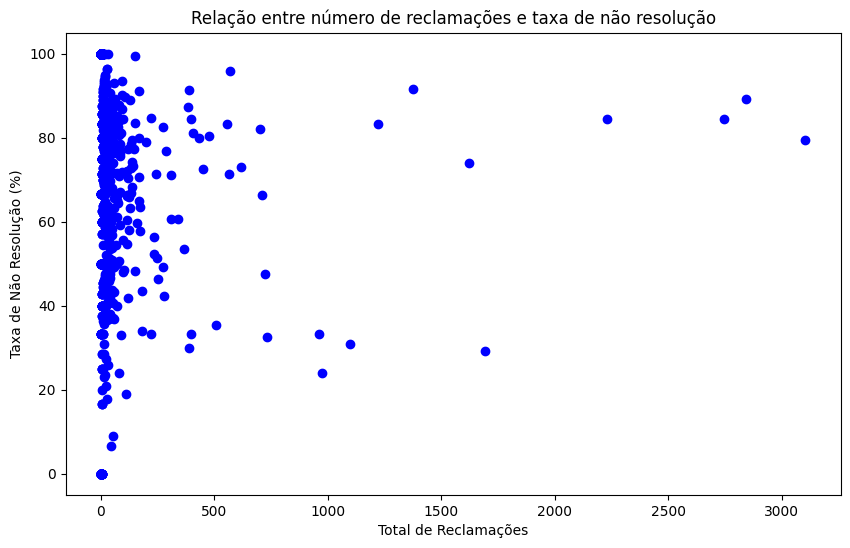

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(taxas['total_reclamacoes'], taxas['taxa_nao_resolucao'], color='blue')

plt.title('Relação entre número de reclamações e taxa de não resolução')
plt.xlabel('Total de Reclamações')
plt.ylabel('Taxa de Não Resolução (%)')

plt.show()

Podemos ver que não há uma relação clara, tanto que, já visualizando a tabela, temos os exemplos:

|     | Company_Name            |   total_reclamacoes |   total_resolvido |   total_nao_resolvido |   taxa_resolucao |   taxa_nao_resolucao |
|----:|:------------------------|--------------------:|------------------:|----------------------:|-----------------:|---------------------:|
| 553 | Serasa Experian         |                 911 |               324 |                   587 |          35.5653 |              64.4347 |
| 641 | Vivo - Telefônica       |                 622 |               551 |                    71 |          88.5852 |              11.4148 |
| 100 | Banco do Brasil         |                 485 |               211 |                   274 |          43.5052 |              56.4948 |
| 374 | Latam Airlines (Tam)    |                 426 |               370 |                    56 |          86.8545 |              13.1455 |
| 158 | Caixa Econômica Federal |                 398 |               201 |                   197 |          50.5025 |              49.4975 |

Em que a **Serasa Experian** é a empresa com mais reclamações e possui uma baixa taxa de resolução, enquanto a **Vivo** possui várias reclamações mas uma alta taxa de resolução.

In [25]:
# 4. A média de nota por empresa
agg_data = (
    data[~data['rating_score'].str.contains('não há')]
        .groupby('company_name').agg(
            media_nota=('nota_tree', 'mean'),
            quantidade_reclamacoes=('company_name', 'count'),
        ).sort_values(
            by='quantidade_reclamacoes', 
            ascending=False
        ).reset_index()
)
agg_data.head()

,company_name,media_nota,quantidade_reclamacoes
0,Serasa Experian,2.683449,1728
1,Vivo - Telefônica,4.160284,1410
2,Banco do Brasil,2.722642,1060
3,Latam Airlines (Tam),4.12203,926
4,Banco Santander,2.395556,900


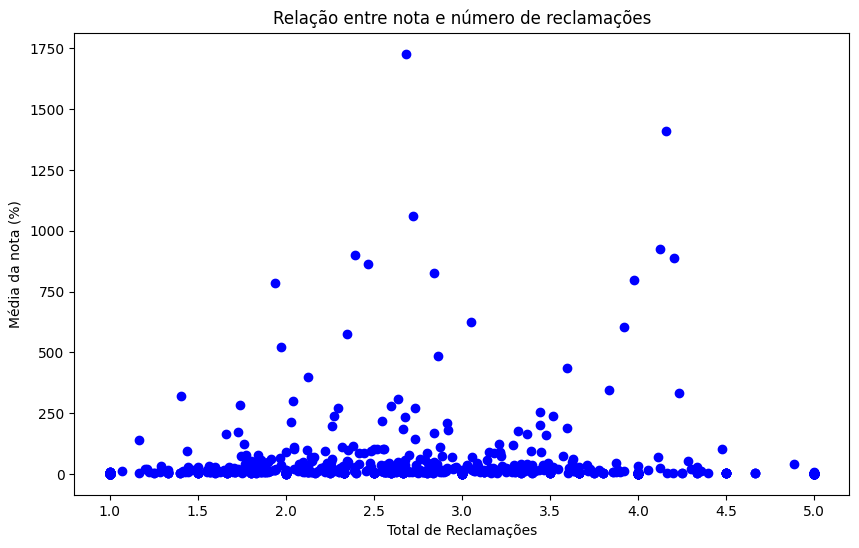

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(agg_data['media_nota'], agg_data['quantidade_reclamacoes'], color='blue')

plt.title('Relação entre nota e número de reclamações')
plt.xlabel('Total de Reclamações')
plt.ylabel('Média da nota (%)')

plt.show()

In [27]:
# 5. Média de nota por reclamações não resolvidas & 6. Distribuição de reclamações resolvidas e não-resolvidas.
score_per_status = (
    data[(data['nota_logit'] != -1) & (data['status'] != 'Não avaliado pelo consumidor')]
        .groupby('status').agg(
            media_nota=('nota_tree', 'mean'),
            quantidade_reclamacoes=('company_name', 'count')
        ).reset_index()
)

score_per_status

,status,media_nota,quantidade_reclamacoes
0,Não Resolvido,1.394498,15630
1,Resolvido,4.248613,16045


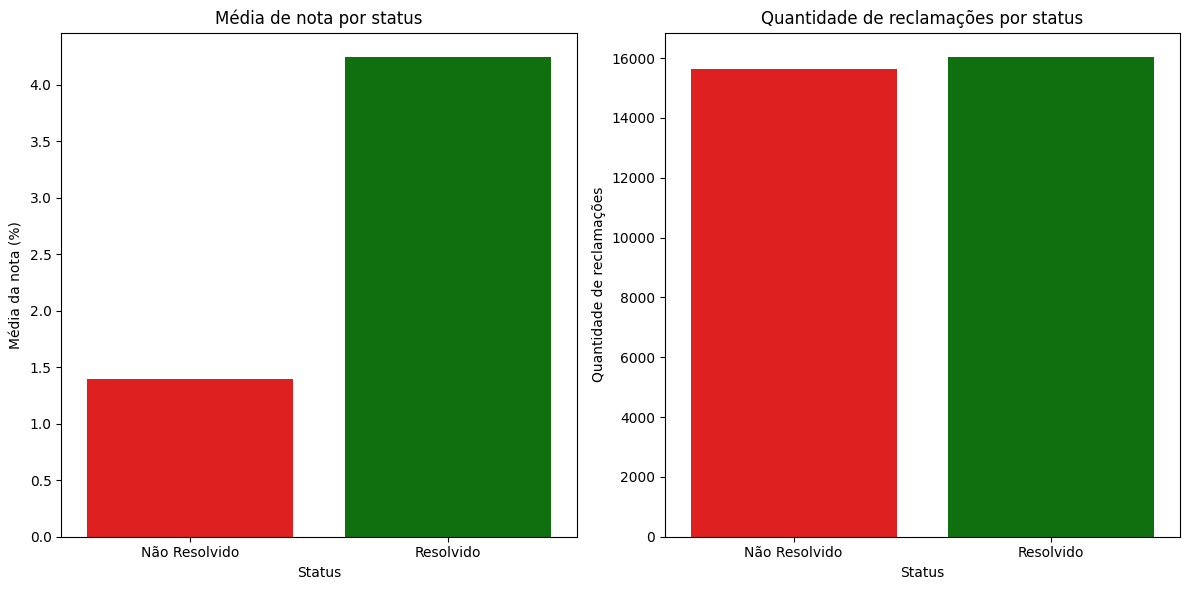

In [28]:
# Green for resolved, red for unresolved
import warnings
warnings.filterwarnings('ignore')

colors = ['green' if status == 'Resolvido' else 'red' for status in score_per_status['status']]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(data=score_per_status, x='status', y='media_nota', ax=ax[0], palette=colors)
ax[0].set_title('Média de nota por status')
ax[0].set_xlabel('Status')
ax[0].set_ylabel('Média da nota (%)')

sns.barplot(data=score_per_status, x='status', y='quantidade_reclamacoes', ax=ax[1], palette=colors)
ax[1].set_title('Quantidade de reclamações por status')
ax[1].set_xlabel('Status')
ax[1].set_ylabel('Quantidade de reclamações')

plt.tight_layout()
plt.show()

In [29]:
from pandas import DataFrame

total_reports = len(data[data['nota_logit'] != -1])
rating_count = data[data['nota_logit'] != -1].groupby('nota_logit')['nota_logit'].count()
df_rating_count = DataFrame({
    'nota':rating_count.index,
    'count':rating_count.values
})
df_rating_count = df_rating_count.assign(proportion = (df_rating_count['count'] / total_reports) * 100)


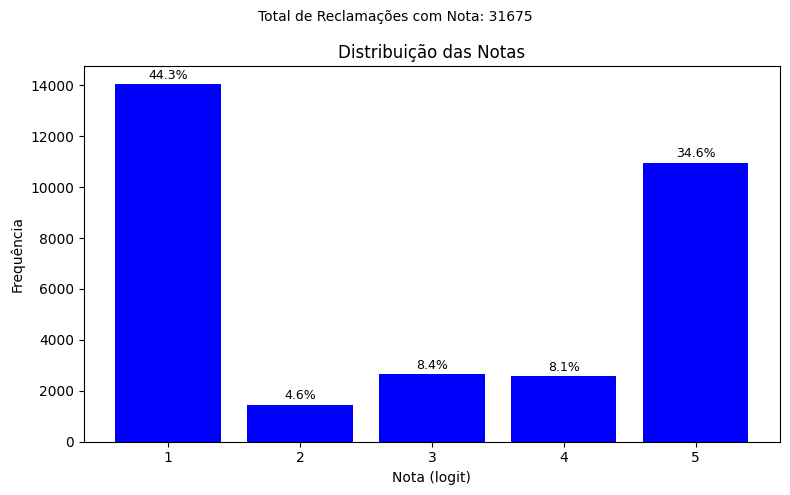

In [30]:
# Plotagem
plt.figure(figsize=(8, 5))
bars = plt.bar(df_rating_count['nota'], df_rating_count['count'], color='blue')

# Rótulos de proporção sobre as barras
for bar, prop in zip(bars, df_rating_count['proportion']):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 100,  # Ajuste vertical
             f"{prop:.1f}%", 
             ha='center', va='bottom', fontsize=9)

# Eixos e títulos
plt.xlabel('Nota (logit)')
plt.ylabel('Frequência')
plt.title('Distribuição das Notas')
plt.suptitle(f'Total de Reclamações com Nota: {total_reports}', fontsize=10)
plt.tight_layout()
plt.show()

**PLN - Processamento de Linguagem Natural**
- 7. Palavras mais frequentes
- 8. Palavras mais frequentes por empresa.
- 9. Palavras mais frequentes nos resolvidos e não resolvidos.

In [31]:
import pandas as pd
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
import re

def preprocess_text(text):
    # Remove pontuação, números e deixa tudo minúsculo
    text = re.sub(r'[^a-zA-ZáéíóúãõâêôçÁÉÍÓÚÃÕÂÊÔÇ]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)


In [33]:
from pandas import DataFrame

# Pré-processa todas as descrições
data['clean_report'] = data['report'].apply(preprocess_text)
data['clean_response'] = data['company_response'].apply(preprocess_text)

# Junta tudo num só texto
all_words = ' '.join(data['clean_report']).split()

# Conta frequência
top_words = Counter(all_words).most_common(20)
print('Top 20 palavras mais frequentes:')

freq_df = DataFrame(top_words, columns=['word', 'frequency'])
freq_df = freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)
freq_df

Top 20 palavras mais frequentes:


,word,frequency
0,valor,28564
1,dia,26030
2,xxx,24363
3,conta,17356
4,banco,16246
5,empresa,15029
6,contato,14970
7,pois,14967
8,nome,13898
9,pagamento,10798


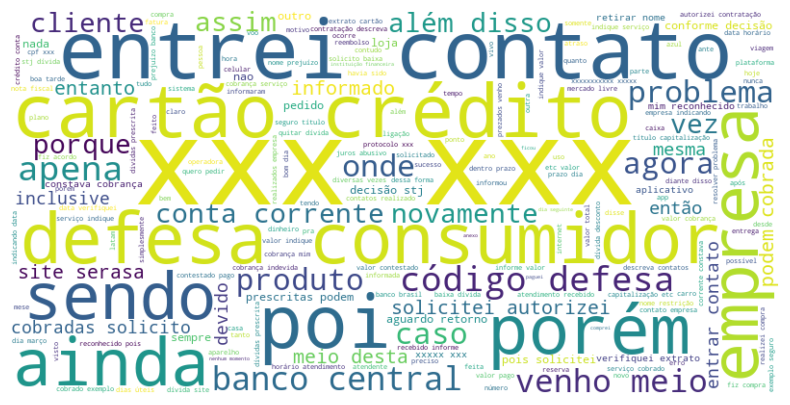

In [34]:
# Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
# Lista para armazenar os dados
freq_data = []

# Iterar pelos status
for company in data['company_name'].unique():
    subset = data[data['company_name'] == company]
    texto = ' '.join(subset['clean_report'])
    palavras = texto.split()
    top = Counter(palavras).most_common(10)

    # Adiciona ao dataframe
    for palavra, freq in top:
        freq_data.append({'empresa': company, 'Palavra': palavra, 'Frequência': freq})

# Criar o DataFrame
df_frequencia_status = DataFrame(freq_data)

In [36]:
# Lista para armazenar os dados
freq_data = []

# Iterar pelos status
for status in data['status'].unique():
    subset = data[data['status'] == status]
    texto = ' '.join(subset['clean_report'])
    palavras = texto.split()
    top = Counter(palavras).most_common(10)

    # Adiciona ao dataframe
    for palavra, freq in top:
        freq_data.append({'Status': status, 'Palavra': palavra, 'Frequência': freq})

# Criar o DataFrame
df_frequencia_status = DataFrame(freq_data)

In [37]:
print('Frequência de palavras por status Resolvido:')
df_frequencia_status[df_frequencia_status['Status'] == 'Resolvido'][['Palavra', 'Frequência']].head(10)

Frequência de palavras por status Resolvido:


,Palavra,Frequência
10,dia,11744
11,valor,9881
12,xxx,9531
13,contato,6399
14,conta,5804
15,empresa,5307
16,cancelamento,5008
17,pois,4869
18,compra,4170
19,plano,4098


In [38]:
print('Frequência de palavras por status Não-Resolvido:')
df_frequencia_status[df_frequencia_status['Status'] == 'Não Resolvido'][['Palavra', 'Frequência']].head(10)

Frequência de palavras por status Não-Resolvido:


,Palavra,Frequência
0,valor,10140
1,dia,9328
2,xxx,9133
3,banco,6829
4,conta,6755
5,pois,5550
6,contato,5502
7,empresa,5471
8,cartão,4191
9,pagamento,4087


---
## **Preparação de Dados**

In [39]:
# Preparação de dados para modelagem com Machine Learning
cols = [col for col in data.columns if col not in ['report', 'clean_report', 'company_response','consumer_written_evaluation']]
data[cols].head()

actual_size = len(data)

In [40]:
status_map = {
    'Resolvido': 1,
    'Não Resolvido': 0
}

data = data[data['status'] != 'Não avaliado pelo consumidor']
new_size = len(data)
data['label'] = data['status'].map(status_map)

In [41]:
print('Tamanho Antigo: ', actual_size)
print('Tamanho Atual', new_size)

Tamanho Antigo:  50000
Tamanho Atual 31675


In [42]:
# Removendo colunas inúteis
columns_to_drop = [
    'status', 
    'report',
    'company_response', 
    'rating_score', 
    'consumer_written_evaluation', 
    'data_reclamacao', 
    'cidade'
]
data_ml = data.drop(columns=columns_to_drop)
data_ml = data_ml[reversed(data_ml.columns)]
data_ml.head()

,label,clean_response,clean_report,nota_logit,nota_tree,consumidor_respondeu,dias_para_resposta,respondido,uf,company_name
0,0,flavia tudo bem acabamos responder solicitação...,solicito imediata retirada negativação indevid...,2,2,True,0,1,RS,Serasa Experian
1,0,karina tudo bem acabamos responder solicitação...,solicito retirada imediata dívida prescrita ai...,1,1,True,0,1,PR,Serasa Experian
2,1,emerson tudo bem acabamos responder solicitaçã...,solicito imediata retirada negativacão indevid...,1,1,True,0,1,AM,Serasa Experian
3,0,washington tudo bem acabamos responder solicit...,solicito retirada imediata cobrança dívidas ci...,3,3,True,0,1,AP,Serasa Experian
4,1,olá tudo bem informamos manifestação respondid...,realizei pagamento acordo quitar dívida descon...,1,1,True,0,1,SP,Cartões Renner (Realize CFI)


---

In [43]:
data_ml_to_csv = data_ml.dropna(subset=['clean_report'])
data_ml_to_csv.to_csv(ml_file_path, sep='|', encoding='utf-8', compression='gzip', index=False)

### **Criando Dados para o Banco de Dados**

In [44]:
database = read_csv(staging_file_path, sep='|', encoding='utf-8')

### **Reclamações**

In [45]:
from numpy import random

reports_table = database.copy()
reports_table = reports_table[reports_table['status'] != 'Não avaliado pelo consumidor']
reports_table['id_company'] = reports_table['company_name'].astype('category').cat.codes + 1
reports_table['id_user'] = random.randint(1, 2000, size=len(data_ml))
reports_table['id_report'] = reports_table.index + 1
reports_table['id_report'] = reports_table['id_report'].astype('int64')
reports_table.head(2)

,company_name,status,date,report,company_response,response_date,rating_score,consumer_written_evaluation,id_company,id_user,id_report
0,Serasa Experian,Não Resolvido,"25/04/2025, Santa Maria - RS",Solicito a imediata retirada da negativação in...,"Oi, FLAVIA. Tudo bem?\r\n\r\n\r\nAcabamos de r...",(no mesmo dia),Nota 2,<não há comentários do consumidor>,695,651,1
1,Serasa Experian,Não Resolvido,"25/04/2025, Santa Tereza do Oeste - PR",“Solicito a retirada imediata da dívida prescr...,"Oi, KARINA. Tudo bem?\r\n\r\n\r\nAcabamos de r...",(no mesmo dia),Nota 1,<não há comentários do consumidor>,695,105,2


### **Usuários**

In [46]:
import random

def generate_cpf():
    numbers = [random.randint(0, 9) for _ in range(9)]

    sum_1 = sum([numbers[i] * (10 - i) for i in range(9)])
    digit_1 = (sum_1 * 10) % 11
    digit_1 = digit_1 if digit_1 < 10 else 0

    sum_2 = sum([numbers[i] * (11 - i) for i in range(9)]) + digit_1 * 2
    digit_2 = (sum_2 * 10) % 11
    digit_2 = digit_2 if digit_2 < 10 else 0

    cpf = f"{''.join(map(str, numbers))}{digit_1}{digit_2}"

    return cpf

print(generate_cpf())

24989118634


In [47]:
import pandas as pd
from faker import Faker
import random
import bcrypt

fake = Faker('pt-br')

def hash_password(password):
    return bcrypt.hashpw(password.encode('utf-8'), bcrypt.gensalt()).decode('utf-8')

def generate_user_data_corrected(id_users, id_companies, total_users=2000, n_empresas=839):
    generated_cpfs = set()
    user_data = []

    cidadao_users_quant = int((total_users - n_empresas) * 0.9)

    company_users_ids = list(range(1, n_empresas + 1))
    cidadaos_ids = list(range(n_empresas+1, cidadao_users_quant+1))
    servidores_ids = list(range(cidadao_users_quant+1, total_users))

    for id_user in company_users_ids:
        nome_usuario = fake.name()
        tipo_usuario = 'empresa'
        email = fake.company_email()
        cpf_user = generate_cpf()

        while cpf_user in generated_cpfs:
            cpf_user = generate_cpf()
        generated_cpfs.add(cpf_user)

        user_data.append([
            id_user,
            nome_usuario,
            tipo_usuario,
            id_user, 
            email,
            cpf_user,
            fake.sha256()
        ])

    for id_user in cidadaos_ids:
        nome_usuario = fake.name()
        tipo_usuario = 'cidadao'
        email = fake.email()
        cpf_user = generate_cpf()

        while cpf_user in generated_cpfs:
            cpf_user = generate_cpf()
        generated_cpfs.add(cpf_user)

        pwd = hash_password(email) if id_user == 1000 else fake.sha256()

        user_data.append([
            id_user,
            nome_usuario,
            tipo_usuario,
            None,
            email,
            cpf_user,
            pwd
        ])

    for id_user in servidores_ids:
        nome_usuario = fake.name()
        tipo_usuario = 'servidor'
        email = fake.user_name() + "@consumidor.gov.br"
        cpf_user = generate_cpf()

        while cpf_user in generated_cpfs:
            cpf_user = generate_cpf()
        generated_cpfs.add(cpf_user)

        user_data.append([
            id_user,
            nome_usuario,
            tipo_usuario,
            None,
            email,
            cpf_user,
            fake.sha256()
        ])

    dataframe = pd.DataFrame(user_data, columns=[
        'id_user',
        'name',
        'user_type',
        'id_company',
        'email',
        'cpf_user',
        'password'
    ])

    return dataframe

users = generate_user_data_corrected(
    id_users=reports_table['id_user'].unique(), 
    id_companies=reports_table['id_company'].unique()
)

users.head()

,id_user,name,user_type,id_company,email,cpf_user,password
0,1,Srta. Maria Alice da Rosa,empresa,1.0,laura94@da.net,98276959245,00f40ae85b2c618306467664c45f89fc4413f099a24c25...
1,2,Maria Luiza Farias,empresa,2.0,heitor39@pires.com,34432131209,36fc3b82554c0fee73eb6fc8edb26a2c7c9af1f75f91e9...
2,3,Joana Duarte,empresa,3.0,duartegabriela@cavalcanti.br,17080726085,c682e3e43c9917c263f0a5afdcd4a36dfb424004cffcee...
3,4,Maria Vitória Barros,empresa,4.0,brunavieira@teixeira.net,89016025391,c9ec6daa7e5a1ff9755013a03582c1009f057824cea2ab...
4,5,Maria Alice Carvalho,empresa,5.0,salesbenjamin@duarte.br,77123581687,7a284893764e6bf38c032c443f25614bc0edace59fffb6...


### **Empresas**

In [48]:
companies = reports_table[['id_company', 'company_name']].drop_duplicates()

In [49]:
reports_table = reports_table.drop(columns=['company_name'])

### **Probabilidades**

In [50]:
src = 'src'
models = 'models'
models_ml = 'ml'
ann_model_path = os.path.join(
    root_path, 
    src,
    models,
    models_ml,
    'ANN_model.keras'
)

In [51]:
from src.models.transformers.preprocessor import Preprocessor
preprocessor = Preprocessor()

In [52]:
data = read_csv(ml_file_path, sep='|', encoding='utf-8', compression='gzip').dropna(subset=['clean_report'])

In [53]:
data['id_report'] = reports_table['id_report']

In [54]:
# load ann_model
from tensorflow.keras.models import load_model
from src.config import Config

ann_model = load_model(Config().model_configs['ANN']['model_path'])
ann_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │        14,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,309 (196.52 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,540 (131.02 KB)

In [55]:
ids = data['id_report']
X = data[data.columns.difference(['id_report', 'label'])]

In [56]:
X_processed = preprocessor.transform(X)

In [57]:
probs = ann_model.predict(X_processed)
preds = probs.flatten()


990/990 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [58]:
predictions = DataFrame({
    'id_report': ids,
    'prediction': preds
})

In [59]:
predictions['predicted_label'] = (predictions['prediction'] > 0.5).astype(int)

In [60]:
predictions['true_label'] = data['label']

In [61]:
predictions.head()

,id_report,prediction,predicted_label,true_label
0,1.0,0.009227,0,0
1,2.0,0.001331,0,0
2,3.0,0.000943,0,1
3,4.0,0.108487,0,0
4,5.0,0.007019,0,1


### **Criando Banco de Dados**

In [62]:
tables = [
    ('reports', reports_table),
    ('users', users),
    ('companies', companies),
    ('predicitons', predictions)
]

In [63]:
src = 'src'
backend = 'backend'
database_dir = 'database'
database_name = 'consumidor_gov_brasil.db'
database_path = os.path.join(root_path, src, backend, database_dir, database_name)

In [64]:
from tinydb import TinyDB

In [65]:
db = TinyDB(database_path, create_dirs=True)

db.drop_tables()

for table_name, df in tables:
    table = db.table(table_name)
    records = df.to_dict(orient='records')
    table.insert_multiple(records)

In [66]:
for table in db.tables():
    print(f'Table: {table}')
    for record in db.table(table).all()[:5]:
        print(record)
    print('\n')

Table: reports
{'status': 'Não Resolvido', 'date': '25/04/2025, Santa Maria - RS', 'report': 'Solicito a imediata retirada da negativação indevida referente a dívida prescrita, com mais de 5 anos, registrada de forma ilegal no Serasa. Caso não seja retirada, tomarei as medidas judiciais cabíveis, inclusive pedido de indenização por danos morais.', 'company_response': 'Oi, FLAVIA. Tudo bem?\r\n\r\n\r\nAcabamos de responder a sua solicitação. Por favor, acesse o campo "Complemento da Reclamação" e confira a resposta.\r\n\r\n\r\nConte com o nosso apoio.\r\n\r\n\r\nEquipe Serasa Experian.', 'response_date': '(no mesmo dia)', 'rating_score': 'Nota 2', 'consumer_written_evaluation': '<não há comentários do consumidor>', 'id_company': 695, 'id_user': 651, 'id_report': 1}
{'status': 'Não Resolvido', 'date': '25/04/2025, Santa Tereza do Oeste - PR', 'report': '“Solicito a retirada imediata da dívida prescrita que ainda consta no meu nome no Serasa/SPC. A manutenção dessa informação fere o CDC (

Usuário Cidadão de Teste:
- email: tda-luz@example.org
- senha: tda-luz@example.org

In [75]:
reports = db.table('reports')
reports_saple = reports.all()[0]

In [76]:
reports_saple

{'status': 'Não Resolvido',
 'date': '25/04/2025, Santa Maria - RS',
 'report': 'Solicito a imediata retirada da negativação indevida referente a dívida prescrita, com mais de 5 anos, registrada de forma ilegal no Serasa. Caso não seja retirada, tomarei as medidas judiciais cabíveis, inclusive pedido de indenização por danos morais.',
 'company_response': 'Oi, FLAVIA. Tudo bem?\r\n\r\n\r\nAcabamos de responder a sua solicitação. Por favor, acesse o campo "Complemento da Reclamação" e confira a resposta.\r\n\r\n\r\nConte com o nosso apoio.\r\n\r\n\r\nEquipe Serasa Experian.',
 'response_date': '(no mesmo dia)',
 'rating_score': 'Nota 2',
 'consumer_written_evaluation': '<não há comentários do consumidor>',
 'id_company': 695,
 'id_user': 651,
 'id_report': 1}